In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy import signal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

dr = '../Recordings/Speller/'
file_1 = 'run_03.xdf'
file_2 = 'run_04.xdf'

# file 'run_03' contains data for spelling 'QUICK'
# file 'run_04' contains data for spelling 'P3EEG'

In [2]:
def speller_file_to_dict(data):
    run = {
        'data': [],
        'time_stamps': [],
        'aux': [],
        'aux_time_stamps': [],
        'markers': [],
        'marker_time_stamps': [],
        'sample_rate': {},
    }
    for stream in data:
        if stream['info']['name'][0] == 'eeg_data':
            run['data'] = stream['time_series']
            run['time_stamps'] = stream['time_stamps']
            run['sample_rate']['eeg'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'aux_data':
            run['aux'] = stream['time_series']
            run['aux_time_stamps'] = stream['time_stamps']
            run['sample_rate']['aux'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'P300_Speller_Markers':
            run['markers'] = stream['time_series']
            run['marker_time_stamps'] = stream['time_stamps']
        else:
            print('Warning unmatched stream name')
            
    return run

data = {
    'run': [],
}

for file_nm in [file_1, file_2]:
    imported_data, _ = pyxdf.load_xdf(dr+file_nm)
    run = speller_file_to_dict(imported_data)
    data['run'].append(run)
    
# print(data)

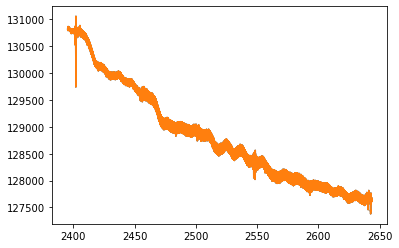

In [3]:
# re-ref test
ear_lobe = -(np.sum(data['run'][1]['data'], axis=1))/8
ref = data['run'][1]['data'][:,0] + ear_lobe
pz_before = data['run'][1]['data'][:,3]
pz_then = pz_before + ear_lobe
pz_after = pz_then - ref
pz_reref = pz_before - data['run'][1]['data'][:,0]
for_plot = np.array([pz_after, pz_reref]).T
_ = plt.plot(data['run'][1]['time_stamps'],  for_plot)

# re-ref HARD:
# extract online reference, add to channel, add to new ref, subtract new ref from channel
# re-ref EASY:
# subtract new ref channel from channels
# in the plot above/below, the two methods are compared and the same result is returned

In [4]:
def plot_time_series(X, Y, labels, xlabel=None, ylabel=None, title=None, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    for i in range(len(Y.T)):
        y = Y[:,i]
        ax.plot(X, y, label=labels[i])
        
    xlabel = xlabel if xlabel is not None else 'Time'
    ylabel = ylabel if ylabel is not None else 'Amplitude'
    title = title if title is not None else 'Time Series'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    _ = ax.legend()
    
    return fig, ax

def add_markers_to_plot(markers, time_stamps, fig, ax):
    for timestamp, marker in zip(time_stamps, markers):
#             if (marker[0] == '1'):
            if '[' in marker[0]:
                ax.axvline(x=timestamp, color='C1')

In [5]:
# =====================
# Re Reference all data
# =====================
def re_reference(session_data, new_ref_ch_idx):
    # returns data with the new reference channel removed... because its zeros
    new_ref = session_data[:,new_ref_ch_idx]
    re_referenced = session_data - new_ref[:,None]
    re_referenced = np.delete(re_referenced, new_ref_ch_idx, axis=1)
    
    return re_referenced

# =====================
# Epochs and windowing
# =====================
def ms_to_samples(duration, rate=250):
    return int((duration/1000.0) * rate)

def get_samples_for_t_range(time_series, time_stamps, t_range, inclusive=False):
    # great for grabbing a window
    if inclusive:
        low_filt = time_stamps >= t_range[0]
    else:
        low_filt = time_stamps > t_range[0]
        
    high_filt = time_stamps < t_range[1]
    index_range = low_filt == high_filt
    data_range = time_series[index_range]
    ts_range = time_stamps[index_range]
    return data_range, ts_range

def get_epoch(data, data_times, stim_time, pre_stim_ms, post_stim_ms, sample_rate):
    # great for grabbing around a stimulus event time.
    
    # TODO: is there a faster way?
    i = (np.abs(data_times - stim_time)).argmin()
    start = i - ms_to_samples(pre_stim_ms, sample_rate)
    stop = i + ms_to_samples(post_stim_ms, sample_rate) + 1
    epoch = data[start:stop]
    
    return epoch


# ==========
# Epoch Prep
# ==========
def dc_offset(epoch_data, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    offset = np.mean(epoch_data, 0)

    return epoch_data - offset


def filter_eeg(epoch_data, sample_rate, f_range):
    # epoch_data should be 2D, (samples, channels)
    nyq = 0.5 * sample_rate
    low_limit = f_range[0] / nyq
    high_limit = f_range[1] / nyq
    
    sos = signal.butter(2, [low_limit, high_limit], btype='bandpass', output='sos')
    sig_filt = signal.sosfiltfilt(sos, epoch_data, axis=0)    
    
    return np.array(sig_filt)

def baseline_center(epoch_data, baseline_duration_ms, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    baseline_samples = ms_to_samples(baseline_duration_ms, sample_rate)
    pre_stimulus = epoch_data[:baseline_samples]
    baseline = np.mean(pre_stimulus, 0)
    
    return epoch_data - baseline


# ================
# Speller Specific
# ================
ltr_key = ['ABCDEF',
           'GHIJKL',
           'MNOPQR',
           'STUVWX',
           'YZ1234',
           '56789_']

answer_key = {
    'Q': [3, 11],
    'U': [4, 9],
    'I': [2, 9],
    'C': [1, 9],
    'K': [2, 11],
    'P': [3, 10],
    '3': [5, 11],
    'E': [1, 11],
    'G': [2, 7],    
}

In [6]:
def prepare_epochs(epochs, sample_rate):
    # epochs should be 3D, (event, samples, channels)
    
    # frequency range for bandpass filter, in Hz
    LOWCUT = 0.1
    HIGHCUT = 15.0
    freq_range = [LOWCUT,HIGHCUT]
    
    # baseline duration, in ms
    baseline_duration = 100
    
    prepped = []
    for epoch in epochs:
        temp_data = dc_offset(epoch, sample_rate)
#         temp_data = filter_eeg(temp_data, sample_rate, freq_range)
        temp_data = baseline_center(temp_data, baseline_duration, sample_rate)
        prepped.append(temp_data)
        
    return np.array(prepped)

In [7]:
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
aux_chs = ['aux ch_1', 'aux ch_2', 'aux ch_3']

# assigning data... a bit redundant but the hope is to help make the pipelining easier
run_1 = data['run'][0]
run_2 = data['run'][1]

r1_eeg = run_1['data']
r1_eeg_ts = run_1['time_stamps']
r1_aux = run_1['aux']
r1_aux_ts = run_1['aux_time_stamps']
r1_markers = run_1['markers']
r1_markers_ts = run_1['marker_time_stamps']

r2_eeg = run_2['data']
r2_eeg_ts = run_2['time_stamps']
r2_aux = run_2['aux']
r2_aux_ts = run_2['aux_time_stamps']
r2_markers = run_2['markers']
r2_markers_ts = run_2['marker_time_stamps']

new_ref_ch_idx = 0
r1_eeg = re_reference(r1_eeg, new_ref_ch_idx)
r2_eeg = re_reference(r2_eeg, new_ref_ch_idx)
del channels[new_ref_ch_idx]

r1_eeg = filter_eeg(r1_eeg, 250, [0.1,15] )
r2_eeg = filter_eeg(r2_eeg, 250, [0.1,15] )

# remove Fp1 channel
r1_eeg = np.delete(r1_eeg, -1, axis=1)
r2_eeg = np.delete(r2_eeg, -1, axis=1)
del channels[-1]

print(channels)
pz = channels.index('Pz')

['FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz']


### Scale Photosensor
During the first run the screen brightness wasn't as it's brightest. Here I scale it up so as to use the same threshold for each.

In [8]:
max_run1 = max(r1_aux[:,1])
max_run2 = max(r2_aux[:,1])
scaler = max_run2/max_run1
r1_aux[:,1] = r1_aux[:,1] * scaler

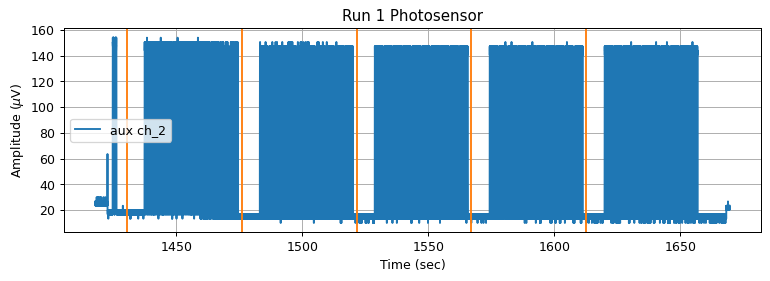

In [9]:
fig, ax = plot_time_series(
    X = r1_aux_ts,
    Y = r1_aux[:,1:2],
    labels = aux_chs[1:2],
    xlabel='Time (sec)',
    ylabel=r'Amplitude ($\mu$V)',
    title='Run 1 Photosensor'
)
add_markers_to_plot(r1_markers, r1_markers_ts, fig, ax)

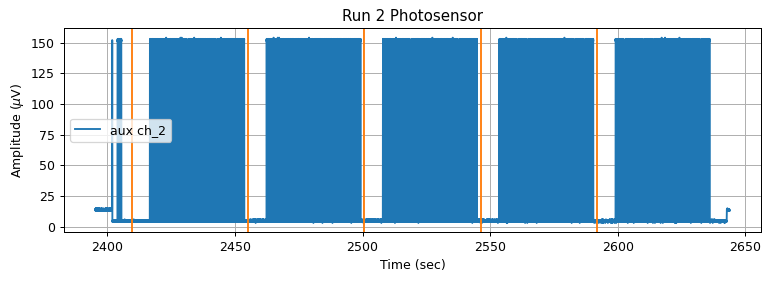

In [10]:
fig, ax = plot_time_series(
    X = r2_aux_ts,
    Y = r2_aux[:,1:2],
    labels = aux_chs[1:2],
    xlabel='Time (sec)',
    ylabel=r'Amplitude ($\mu$V)',
    title='Run 2 Photosensor'
)
add_markers_to_plot(r2_markers, r2_markers_ts, fig, ax)

### Sync photosensor with trials and organize markers

In [11]:
# clean and prep aux channel 0010010
# get associated markers and time stamps
# get trials of markers and time stamps
def get_ts_for_on_rise_threshold(data, data_ts, threshold):
    thr = (data > threshold) + 0
    rise = thr[1:] > thr[:-1]
    rise = np.insert(rise, 0, False) # accounts for lost position above
    return data_ts[rise]

PHOTO_SENSOR_THRESHOLD = 70 # this is based on a visual plot.
r1_photosensor_onsets = get_ts_for_on_rise_threshold(r1_aux[:,1], r1_aux_ts, PHOTO_SENSOR_THRESHOLD)
r2_photosensor_onsets = get_ts_for_on_rise_threshold(r2_aux[:,1], r2_aux_ts, PHOTO_SENSOR_THRESHOLD)

# We happen to know there are 600 stimulus onsets for these trials.
# 5 letters * 10 runs * 12 stimuli/rows_columns = 600
# TODO: automate this!
# There are 2 test sensor blinks that we can get rid of and there is a
# graphical blink at the very beginning of run 2 that needs to be removed.
r1_photosensor_onsets = r1_photosensor_onsets[2:]
r2_photosensor_onsets = r2_photosensor_onsets[3:]

def divide_markers(markers):
    # rc = row and column
    marker_collection = []
    target_collection = []
    y_collection = []
    for marker_arr in markers:
        marker = marker_arr[0]
        if '[' in marker:
            lbl = marker.split('[')[1].split(']')[0]
            target_collection.append(lbl)
            marker_collection.append([])
            y_collection.append([])
        elif marker.isnumeric():
            marker = int(marker)
            marker_collection[-1].append(marker)
            key = answer_key[target_collection[-1]]
            if marker in key:
                y_collection[-1].append(1)
            else:
                y_collection[-1].append(0)
                
    
    return target_collection, np.array(marker_collection), np.array(y_collection)

r1_target_ltr, r1_stim_markers, r1_y = divide_markers(r1_markers)
r2_target_ltr, r2_stim_markers, r2_y = divide_markers(r2_markers)

In [12]:
# Epoch durations in ms
PRE_STIM = 100
POST_STIM = 800

SAMPLE_RATE = 250.0 # Hz

# Make Epochs
r1_epochs = []
for time in r1_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r1_eeg, r1_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r1_epochs.append(epoch)
    
r2_epochs = []
for time in r2_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r2_eeg, r2_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r2_epochs.append(epoch)
    

# Prep Epochs
r1_epochs = prepare_epochs(r1_epochs, SAMPLE_RATE)
r2_epochs = prepare_epochs(r2_epochs, SAMPLE_RATE)

## Quick look at Pz Avg Target/Non-Target

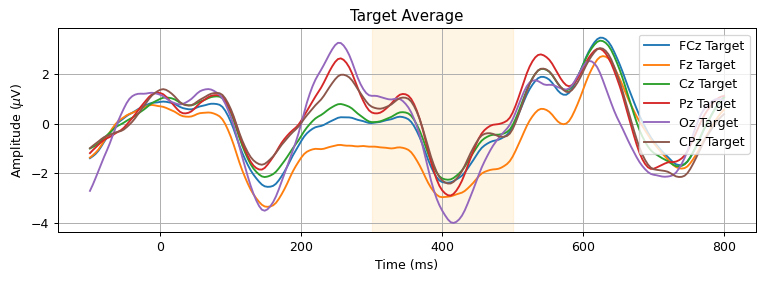

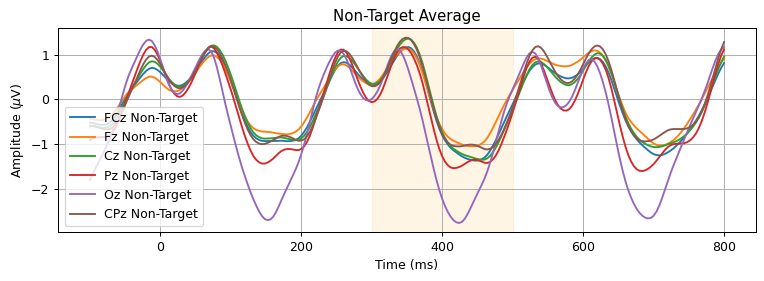

In [13]:
y = r2_y.flatten()
target_epochs = r2_epochs[y == 1]
non_target_epochs = r2_epochs[y == 0]

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r2_epochs.shape[1])]

# average over epochs
# Pz_target_epoch_avg = np.mean(target_epochs[:,:,pz], axis=0)
# Pz_non_target_epoch_avg = np.mean(non_target_epochs[:,:,pz], axis=0)

# fig, ax = plt.subplots(figsize = (10, 5), dpi = 90)
# ax.axvspan(300, 500, color='orange', alpha=0.1)

# ax.plot(x_for_plot, Pz_target_epoch_avg, label=f'{channels[pz]} Target avg.')
# ax.plot(x_for_plot, Pz_non_target_epoch_avg, label=f'{channels[pz]} Non-Target avg.')

# ax.set_xlabel('Time (ms)')
# ax.set_ylabel(r'Amplitude ($\mu$V)')
# ax.set_title(f'{channels[pz]} Average')
# ax.grid(True)
# _ = ax.legend()

target_epoch_avg = np.mean(target_epochs, axis=0)*-1
non_target_epoch_avg = np.mean(non_target_epochs, axis=0)*-1

# aux_epoch_avg = np.mean(r1_aux_epochs[:,:,1], axis=0)

# ch_avg = np.hstack((target_epoch_avg, non_target_epoch_avg))

# g_labels = [ch + 'Target' for ch in channels] + [ch + 'Non-Target' for ch in channels]
# fig, ax = plot_time_series(
#     x_for_plot,
#     ch_avg,
#     labels = g_labels,
#     xlabel='Time (ms)',
#     ylabel=r'Amplitude ($\mu$V)',
#     title=f'Channel Average'
# )
# _ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = [ch + ' Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    target_epoch_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = [ch + ' Non-Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    non_target_epoch_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Non-Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

In [14]:
# notes: markers ahead of photosensor. No photosensor for '[P]3EEG'
# first aux blink is red flash = trash
# calibration blinks are 1s apart, followed by ~12s
print(r2_markers[:4])
print(r2_markers_ts[:4])
print(r2_photosensor_onsets[:2])

[['P3EEG'], ['[P]3EEG'], ['4'], ['6']]
[2400.80030268 2409.50471681 2415.57397392 2415.85420843]
[2416.5967905 2416.8807906]


In [15]:
Y = r2_y.flatten()
Y2 = r1_y.flatten()

X_Pz = r2_epochs[:,:,pz]
X2_Pz = r1_epochs[:,:,pz]

def balance_zeros(data, y):
    # truncates the zeros down to the same size as ones.
    # assumes more zeros than ones
    zeros = np.sum(y == 0)
    ones = np.sum(y == 1)
    step = int(zeros/ones)
    print(f'{100*zeros/y.shape[0]:.2f}% zeros')
    sort_order = np.argsort(y, kind='stable')
    half_zeros = [i for i in range(0,zeros,step)]
    sort_order = np.concatenate((sort_order[half_zeros], sort_order[-ones:]), axis=0)
    orig_order = np.sort(sort_order)
    y_part = y[orig_order]
    data_part = data[orig_order]
    
    return data_part, y_part
#     return data, y

X_Pz_trunc, y_trunc = balance_zeros(X_Pz, Y)
X2_Pz_trunc, y2_trunc = balance_zeros(X2_Pz, Y2)

X_Pz_comb = np.concatenate((X_Pz_trunc, X2_Pz_trunc))
y2_comb = np.concatenate((y_trunc, y2_trunc))

83.33% zeros
83.33% zeros


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_Pz_comb, y2_comb, test_size=0.20, random_state=24)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

Simple 20% test split accuracy: 0.5625


In [17]:
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
scores = cross_val_score(LDA_clf, X_Pz_comb, y2_comb, cv = 5)
print(f'Cross Validataion scores: {scores}')

Cross Validataion scores: [0.5375 0.7125 0.6375 0.425  0.5625]


## Online Simulation
Using the first letter runs to train the LDA classifier, then test on the last letter. This can be randomized and performed for each letter.
Probably just using one electrode...Pz

In [18]:
def window_and_combine_features(epochs, sub_samples_per_ch, time_window):
    # epochs is expected to be 3D, (epoch, sample, channel)
    
    t_start = ms_to_samples(time_window[0], 250)
    t_len = ms_to_samples(time_window[1] - time_window[0], 250)
    
#     epoch_len = epochs.shape[1]
#     window_len = np.round(epoch_len/sub_samples_per_ch).astype(int)
#     windowed = np.zeros(( len(epochs), epochs.shape[-1], sub_samples_per_ch))
    
#     epoch_len = epochs.shape[1]
    window_len = np.round(t_len/sub_samples_per_ch).astype(int)
    windowed = np.zeros(( len(epochs), epochs.shape[-1], sub_samples_per_ch))
    
    for i in range(sub_samples_per_ch):
        win_start = i * window_len + t_start
        win_stop = win_start + window_len
        win_avg = np.mean(epochs[:,win_start:win_stop,:], axis=1) # (epochs x ch)
        windowed[:,:,i] = win_avg

    windowed = windowed.reshape((len(epochs), epochs.shape[-1] * sub_samples_per_ch))

    return windowed

def test_LDA_prediction(target_ltrs, stim_labels, epochs, y, channel):
    for i, target_ltr in enumerate(target_ltrs):
        test_epoch = epochs[i]
        test_stim_labels = stim_labels[i]
        test_y = y[i]
        train_epochs = np.delete(epochs, i, 0)
        train_stim_labels = np.delete(stim_labels, i, 0)
        train_y = np.delete(y, i, 0)
        train_y = train_y.flatten()
        
        shp = train_epochs.shape

        if channel is not None:
            test_epoch = test_epoch[:,:,channel]
            train_x = train_epochs.reshape(shp[0] * shp[1], shp[2], shp[3])
            train_x = train_x[:,:,channel]
        else:
            train_x = train_epochs.reshape(shp[0] * shp[1], shp[2])
        
        train_x, train_y = balance_zeros(train_x, train_y)
        LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        LDA_clf = LDA_clf.fit(train_x, train_y)
        print(f'classifier score: {LDA_clf.score(test_epoch, test_y)}')
        
        confidence = LDA_clf.predict_proba(test_epoch)

        conf_avg = []
        for j in range(len(ltr_key)*2):
            avg = np.mean(confidence[test_stim_labels == j, 1])
            conf_avg.append(avg)
            
#         print(conf_avg)
            
        conf_avg_rows = conf_avg[:len(ltr_key)]
        conf_avg_cols = conf_avg[len(ltr_key):]
        
        max_row = np.argmax(conf_avg_rows)
        max_col = np.argmax(conf_avg_cols)
        print(f'-- Run: {i}, Results --')
        print(f'row choice: {max_row}, column choice: {max_col}')
        result = ltr_key[max_row][max_col]
#         print(result == target_ltr)
        print(result, target_ltr)

In [19]:
# **************************
# run 2 - test
# **************************

# r2_target_ltr, r2_stim_markers, r2_y, r2_epochs
# dims: (5)    , (5,120)       , (5,120), (600,226,7)
# we need the epochs to match the 5x120 instead of 600
# so reshape(5,120,266,7) 
# shp = r2_stim_markers.shape + r2_epochs.shape[1:]
# r2_epochs_by_target = np.reshape(r2_epochs, shp)

# r2_win_epochs = window_and_combine_features(r2_epochs, 5)
# shp = r2_stim_markers.shape + r2_win_epochs.shape[-1:]
# r2_win_epochs_by_target = np.reshape(r2_win_epochs, shp)

# print('\n==== vv NON-WINDOWED vv ====\n')
# test_LDA_prediction(r2_target_ltr, r2_stim_markers, r2_epochs_by_target, r2_y, pz)
# print('\n==== vv WINDOWED vv ====\n')
# test_LDA_prediction(r2_target_ltr, r2_stim_markers, r2_win_epochs_by_target, r2_y, None)

# **************************
# combined run - test
# **************************

all_markers = np.concatenate((r1_markers, r2_markers))
all_target_ltr, all_stim_markers, all_y = divide_markers(all_markers)

all_epochs = np.concatenate((r1_epochs, r2_epochs))

shp = all_stim_markers.shape + all_epochs.shape[1:]
all_epochs_by_target = np.reshape(all_epochs, shp)

all_win_epochs = window_and_combine_features(all_epochs, 5, (200, 600))
shp = all_stim_markers.shape + all_win_epochs.shape[-1:]
all_win_epochs_by_target = np.reshape(all_win_epochs, shp)

print('\n==== vv NON-WINDOWED vv ====\n')
test_LDA_prediction(all_target_ltr, all_stim_markers, all_epochs_by_target, all_y, pz)
print('\n==== vv WINDOWED vv ====\n')
test_LDA_prediction(all_target_ltr, all_stim_markers, all_win_epochs_by_target, all_y, None)

# **************************
# run 1 - test
# **************************

# shp = r1_stim_markers.shape + r1_epochs.shape[1:]
# r1_epochs_by_target = np.reshape(r1_epochs, shp)

# r1_win_epochs = window_and_combine_features(r1_epochs, 5)
# shp = r1_stim_markers.shape + r1_win_epochs.shape[-1:]
# r1_win_epochs_by_target = np.reshape(r1_win_epochs, shp)

# test_LDA_prediction(r1_target_ltr, r1_stim_markers, r1_epochs_by_target, r1_y, pz)
# print('\n==== vv WINDOWED vv ====\n')
# test_LDA_prediction(r1_target_ltr, r1_stim_markers, r1_win_epochs_by_target, r1_y, None)


==== vv NON-WINDOWED vv ====

150.00% zeros
classifier score: 0.49166666666666664
-- Run: 0, Results --
row choice: 3, column choice: 3
V Q
150.00% zeros
classifier score: 0.43333333333333335
-- Run: 1, Results --
row choice: 1, column choice: 1
H U
150.00% zeros
classifier score: 0.4166666666666667
-- Run: 2, Results --
row choice: 3, column choice: 1
T I
150.00% zeros
classifier score: 0.4583333333333333
-- Run: 3, Results --
row choice: 3, column choice: 1
T C
150.00% zeros
classifier score: 0.475
-- Run: 4, Results --
row choice: 2, column choice: 4
Q K
150.00% zeros
classifier score: 0.45
-- Run: 5, Results --
row choice: 5, column choice: 2
7 P
150.00% zeros
classifier score: 0.5833333333333334
-- Run: 6, Results --
row choice: 4, column choice: 4
3 3
150.00% zeros
classifier score: 0.5416666666666666
-- Run: 7, Results --
row choice: 5, column choice: 5
_ E
150.00% zeros
classifier score: 0.475
-- Run: 8, Results --
row choice: 1, column choice: 3
J E
150.00% zeros
classifier s

In [20]:
solo_epochs = []
dual_epochs = []
dual_post_epochs = []
zero_pre_epochs = []
zero_post_epochs = []
zero_zero_epochs = []
yy = all_y.flatten().astype(int)
for i, y in enumerate(yy):
    if i > 0 and i < len(yy)-1:
        prev = i - 1
        next_i = i + 1
        prev_y = yy[prev]
        next_y = yy[next_i]
        if y == 1 and y == next_y:
#             print(i)
#             dual_epochs.append(1)
            dual_epochs.append(all_epochs[i])
        elif y == 1:
            if prev_y == 0:
                solo_epochs.append(all_epochs[i])
            else:
                dual_post_epochs.append(all_epochs[i])
                
            zero_post_epochs.append(all_epochs[next_i])
            
        elif y == 0 and y == next_y and y == prev_y:
            zero_zero_epochs.append(all_epochs[i])
        elif y == 0  and next_y == 1:
            zero_pre_epochs.append(all_epochs[i])
            
solo_epochs = np.array(solo_epochs)
dual_epochs = np.array(dual_epochs)
dual_post_epochs = np.array(dual_post_epochs)
zero_pre_epochs = np.array(zero_pre_epochs)
zero_post_epochs = np.array(zero_post_epochs)
zero_zero_epochs = np.array(zero_zero_epochs)

print(len(solo_epochs))
print(len(dual_epochs))
print(len(dual_post_epochs))
print(len(zero_pre_epochs))
print(len(zero_post_epochs))
print(len(zero_zero_epochs))
print(len(solo_epochs) + len(dual_epochs) + len(dual_post_epochs) + len(zero_pre_epochs) + len(zero_post_epochs) + len(zero_zero_epochs))

# for epoch in all_y:
#     print(epoch)

# for h in all_y.flatten():
#     print(h)

154
23
23
177
177
656
1210


In [21]:
x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(solo_epochs.shape[1])]

def draw_future_stim(axis):
    for i in range(6):
        timestamp = 133 + i*133
        axis.axvline(x=timestamp, color='C8')


solo_epochs_avg = np.mean(solo_epochs, axis=0)
dual_epochs_avg = np.mean(dual_epochs, axis=0)
dual_post_epochs_avg = np.mean(dual_post_epochs, axis=0)
zero_pre_epochs_avg = np.mean(zero_pre_epochs, axis=0)
zero_post_epochs_avg = np.mean(zero_post_epochs, axis=0)
zero_zero_epochs_avg = np.mean(zero_zero_epochs, axis=0)


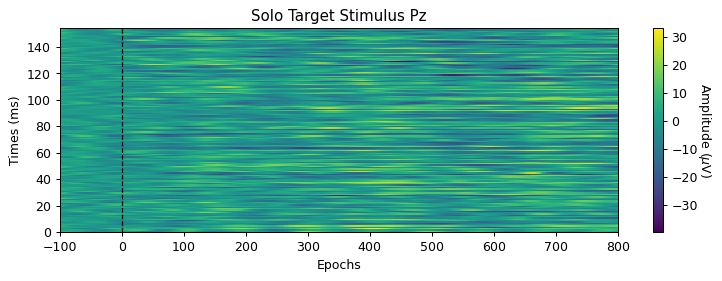

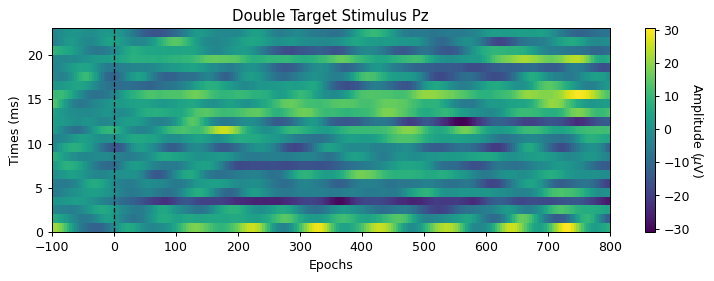

In [22]:
def plot_epochs(ch_epochs, xlabel='Epochs', ylabel='Times (ms)', title='Epoch Comparison', tmin=None, tmax=None):
#     if fig is None and ax is None:
    fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    if tmin == None or tmax == None:
        tmin = 0
        tmax = ch_epochs.shape[-1]
    extent = [tmin, tmax, 0, len(ch_epochs)]
    
    plot = ax.matshow(ch_epochs, interpolation='nearest', origin='lower', aspect='auto', extent=extent)

    ax.xaxis.set_ticks_position("bottom")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.axis('auto')
    ax.axis('tight')
    ax.axvline(0, color='k', linewidth=1, linestyle='--')

    cbar = fig.colorbar(plot)
    cbar.ax.set_ylabel(r'Amplitude ($\mu$V)', rotation=270, labelpad=12)
    
    return fig, ax

img = solo_epochs[:,:,pz]

# img = all_epochs[yy==1,:,pz]
_ = plot_epochs(img,
                title='Solo Target Stimulus Pz',
                tmin=x_for_plot[0],
                tmax=x_for_plot[-1]
               )

img = dual_epochs[:,:,pz]
_ = plot_epochs(img,
                title='Double Target Stimulus Pz',
                tmin=x_for_plot[0],
                tmax=x_for_plot[-1]
               )


(6, 6)
(1200, 226, 6)


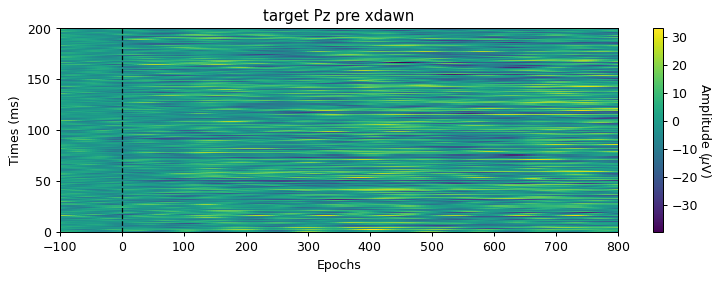

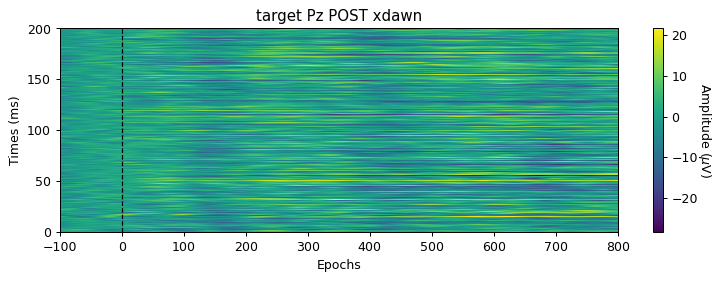

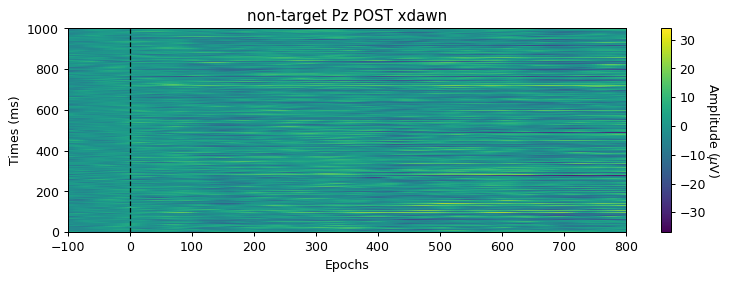

In [23]:
from scipy import linalg
    

def compute_covariance(data, method, method_params, cv, scaling, n_jobs, stop_early, rank):
    orig_rank = rank

    # compute rank
    rank = np.linalg.matrix_rank(data)

    pass

def regularized_covariance(data, reg=None, method_params=None, info=None, rank=None):
    # return cov (n_channels, n_channels)
    reg = 'empirical'
    
    # compute rank
    rank = np.linalg.matrix_rank(data)
    
    
    cov = np.cov(data.T)
    return cov

def mne_xdawn_simple(epochs_data, y, n_components):
    classes = np.unique(y)
    
    # whitening covariance
    signal_cov = regularized_covariance(np.vstack(epochs_data), rank='full')
    
    evokeds, toeplitzs = list(), list()
    for c in classes:
        # averaged
        evokeds.append(np.mean(epochs_data[y==c,:,:], axis=0))
        toeplitzs.append(1.) # pointless
        
    filters = []
    patterns = []
    for evo, toeplitz in zip(evokeds, toeplitzs):
        # estimate cov matrix of prototype
        evo = np.dot(evo.T, toeplitz)
        evo_cov = np.cov(evo)
        
        evals, evecs = linalg.eigh(evo_cov, signal_cov)
        
        evecs = evecs[:, np.argsort(evals)[::-1]]  # sort eigenvectors
        evecs /= np.apply_along_axis(np.linalg.norm, 0, evecs)
        _patterns = np.linalg.pinv(evecs.T)
        filters.append(evecs[:, :n_components].T)
        patterns.append(_patterns[:, :n_components].T)
        
    
    # toeplitz
    # least square evoked (epochs(ch,times), events, tmin, sfreq)
    
    
    filters = np.concatenate(filters, axis=0)
    patterns = np.concatenate(patterns, axis=0)
#     evokeds = np.array(evokeds)

    return filters, patterns #, evokeds


xd_filters, xd_patterns = mne_xdawn_simple(all_epochs, yy, 3)


def transform(data, filters):
    
    ep_copy = np.copy(data)
    for i, epoch in enumerate(ep_copy):
        ep_copy[i] = np.dot(filters, epoch.T).T
        
    return ep_copy
    
# all_epochs.shape
print(xd_filters.shape)
# np.dot(filters, all_epochs[0].T).shape
xd_all_epochs = transform(all_epochs, xd_filters)
print(xd_all_epochs.shape)

# print(xd_all_epochs)
_ = plot_epochs(all_epochs[yy==1,:,pz],
                title='target Pz pre xdawn',
                tmin=x_for_plot[0],
                tmax=x_for_plot[-1]
               )
_ = plot_epochs(xd_all_epochs[yy==1,:,pz],
                title='target Pz POST xdawn',
                tmin=x_for_plot[0],
                tmax=x_for_plot[-1]
               )
_ = plot_epochs(xd_all_epochs[yy==0,:,pz],
                title='non-target Pz POST xdawn',
                tmin=x_for_plot[0],
                tmax=x_for_plot[-1]
               )


In [24]:
# toeplitz

# construct_raw_signal_from_epochs
n_epochs = all_epochs.shape[0]
n_times = all_epochs.shape[1]
n_channels = all_epochs.shape[2]
# in seconds
tmin = PRE_STIM * 1e-3
n_min = int(tmin*SAMPLE_RATE)
tmax = (n_times)/SAMPLE_RATE
print(tmax, n_times, n_min, tmin)
n_max = int(tmax*SAMPLE_RATE)
window = n_max - n_min
print('window:', window, n_max)

# n_samples = 125034
# n_samples = r1_eeg.shape[0] + r2_eeg.shape[0]
# print(n_samples)
# trig = np.zeros((n_samples, 1))
# sel = yy == 1
all_event_times = np.concatenate((r1_photosensor_onsets, r2_photosensor_onsets))

# event onset time, event label/class
all_events = np.vstack((all_event_times, yy.astype(int))).T

print(PRE_STIM, POST_STIM)
fake_raw_start = np.min(all_events[:,0]) - PRE_STIM/1000
print('fake_raw_start', fake_raw_start, 'real', all_events[0,0])
fake_raw_stop  = np.max(all_events[:,0]) + POST_STIM/1000
fake_raw_samples = int((fake_raw_stop - fake_raw_start) * SAMPLE_RATE) + 2
events_pos = ((all_events[:,0])*SAMPLE_RATE).astype(int) - ((all_events[0,0]) * SAMPLE_RATE).astype(int)
print(fake_raw_samples)
print(events_pos[:5])
print(events_pos[-5:])
print(n_times)

raw = np.zeros((fake_raw_samples, n_channels))
for i in range(n_epochs):
    onset = events_pos[i]
    offset = onset + n_times
    raw[onset:offset, :] = all_epochs[i]
    
# print(raw[-1:])
# print(all_epochs[n_epochs-1,-1,:])
# print('\n')
# print(raw[:1])
# print(all_epochs[0,0,:])

n_samples = raw.shape[0]
toeplitz = list()
classes = np.unique(all_events[:,1])
for i, this_class in enumerate(classes):
    sel = all_events[:,1] == this_class
    trig = np.zeros((n_samples, 1))
    ix_trig = (events_pos[sel]) + n_min
    trig[ix_trig] = 1
    toeplitz.append(linalg.toeplitz(trig[0:window], trig))

toeplitz = np.array(toeplitz)
X = np.concatenate(toeplitz)

# least square est
predictor = np.dot(linalg.pinv(np.dot(X, X.T)), X)
evokeds = np.dot(predictor, raw)
evokeds = np.transpose(np.vsplit(evokeds, len(classes)), (0,2,1))

0.904 226 25 0.1
window: 201 226
100 800
fake_raw_start 1437.329848755117 real 1437.4298487551168
299837
[  0  71 142 213 284]
[299340 299407 299478 299544 299611]
226


In [25]:
print(evokeds.shape, toeplitz.shape)
assume_centered = True
n_components = 2
print('begin')
def reg_covariance(data):
    # data should be of shape (all_samples, n_channels)
    # where all_samples = n_epochs x n_samples
    # consider this version of rank in future
    # https://github.com/mne-tools/mne-python/blob/b579d328cb67d6a0096ff5ba74e4e2e557e84065/mne/rank.py#L21
#     print('...rank')
    rank = np.linalg.matrix_rank(data)
    print('rank:', rank)

    # if scaling, scale HERE
    
#     print('...C')
    # covariance
    C = np.dot(data.T, data) # watch the data shape, could be data.T * data
#     print('C shape:', C.shape)

    # whitening
#     print('...eigh')
    eig, eigvec = np.linalg.eigh(C)
#     print('...conj')
    eigvec = eigvec.conj().T
    mask = np.ones(len(eig), bool)
    
    eig[:-rank] = 0.0
    mask[:-rank] = False
    
    eigvec = eigvec[mask]
#     print('...data . eigvec')
    data_eig = np.dot(data, eigvec.T)
    used = np.where(mask)[0]
    
    # compute 'empirical' covariance
    data_ = data_eig.copy()
    X = np.asarray(data_)
    
    if X.ndim == 1:
        X = np.reshape(X, (1,-1))

    if X.shape[0] == 1:
        warnings.warn("Only one sample available. "
                      "You may want to reshape your data array")

#     print('...covariance')
    if assume_centered:
        covariance = np.dot(X.T, X) / X.shape[0]
    else:
        covariance = np.cov(X.T, bias=1)
        
    # project back
#     print('...proj')
    covariance = np.dot(eigvec.T, np.dot(covariance, eigvec))
    # undo bias
#     print('...bias')
    covariance *= data.shape[0]/(data.shape[0] - 1)
    
    return covariance
    
# compute whitening covariance for the raw signal
epoch_stack = np.vstack(all_epochs) # n_e*n_s x n_c
# print(epoch_stack.shape)
sig_cov = reg_covariance(epoch_stack)
# sig_cov_2 = np.cov(epoch_stack)
print('sig_cov', sig_cov.shape)
# print('sig_cov_2', sig_cov_2.shape)
# print(sig_cov.shape)


    
# n_components = 2
# evecs = evecs[:, np.argsort(evals)[::-1]]  # sort eigenvectors
# evecs /= np.apply_along_axis(np.linalg.norm, 0, evecs)
# _patterns = np.linalg.pinv(evecs.T)
# e_filter = evecs[:, :n_components].T
# e_pattern = _patterns[:, :n_components].T

# print(e_filter.shape)

# evokeds, toeplitzs = list(), list()
# for c in classes:
#     # averaged
#     evokeds.append(np.mean(epochs_data[y==c,:,:], axis=0))
#     toeplitzs.append(1.) # pointless

toeplitzs = toeplitz

filters = []
patterns = []
for evo, toe in zip(evokeds, toeplitzs):
    # estimate cov matrix of prototype
#     print(evo.shape,toe.shape)
    evo = np.dot(evo, toe)
#     print(evo.shape)
#     evo_cov = np.cov(evo)
    evo_cov = reg_covariance(evo.T)
#     print(evo_cov.shape)

#     evals, evecs = linalg.eigh(evo_cov, signal_cov)
    try:
#         evals, evecs = np.linalg.eigh((evo_cov, sig_cov))
        evals, evecs = linalg.eigh(evo_cov, sig_cov)
    except np.linalg.LinAlgError as exp:
        print('FAIL')
    
    evecs = evecs[:, np.argsort(evals)[::-1]]  # sort eigenvectors
    evecs /= np.apply_along_axis(np.linalg.norm, 0, evecs)
    _patterns = np.linalg.pinv(evecs.T)
    filters.append(evecs[:, :n_components].T)
    patterns.append(_patterns[:, :n_components].T)


# # toeplitz
# # least square evoked (epochs(ch,times), events, tmin, sfreq)


filters = np.concatenate(filters, axis=0)
patterns = np.concatenate(patterns, axis=0)

print('filter:', filters.shape)

# all_epochs.shape # n_epochs, n_times, n_channels
# np.hstack(all_epochs).shape
# _reg_cov(np.hstack(epochs_data))
# signal_cov.shape

# ee, eev = np.linalg.eigh(C)
# print(eigvec)
# pick = np.ix_([0,1,2,3,4],[0,1,2,3,4])
# print(eigvec[pick])
# 6 x 125034
# raw.shape

def transform_two(data, x_filters):
    # change x to n_e, n_c, n_s
    X = np.swapaxes(data, 1, 2)
    if x_filters.shape[1] != X.shape[1]:
        print('channels and filters don\'t match')

    print('t_two')
    print(X.shape)
    X = np.dot(x_filters, X)
    print(X.shape)
    X = X.transpose((1, 0, 2))
    print(X.shape)
    X = np.swapaxes(X, 1, 2)
    print(X.shape)
    return X
    

(2, 6, 201) (2, 201, 299837)
begin
rank: 6
sig_cov (6, 6)
rank: 6
rank: 6
filter: (4, 6)


t_two
(1200, 6, 226)
(4, 1200, 226)
(1200, 4, 226)
(1200, 226, 4)
(1200, 226, 6)


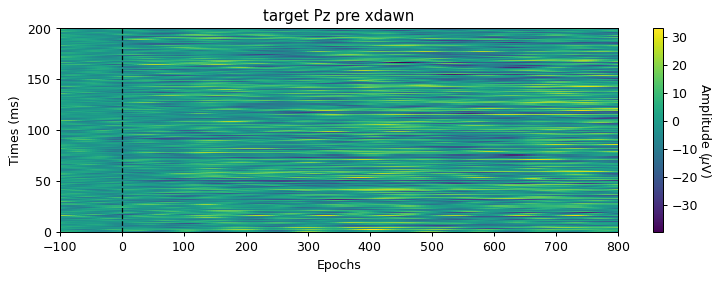

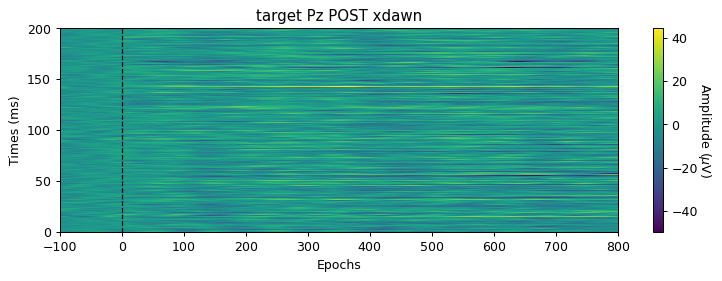

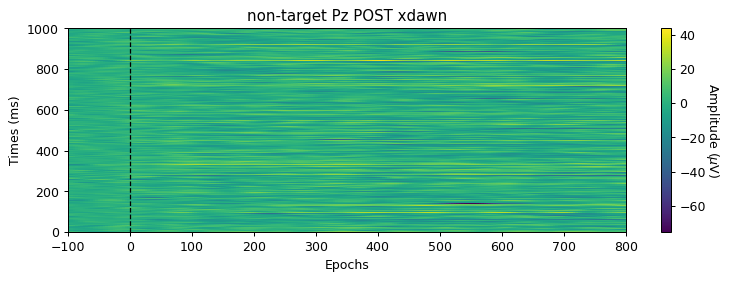

In [26]:
xd_all_epochs = transform_two(all_epochs, filters)
print(all_epochs.shape)
# print(xd_all_epochs.shape)
# print(xd_all_epochs)
_ = plot_epochs(all_epochs[yy==1,:,pz],
                title='target Pz pre xdawn',
                tmin=x_for_plot[0],
                tmax=x_for_plot[-1]
               )
_ = plot_epochs(xd_all_epochs[yy==1,:,pz],
                title='target Pz POST xdawn',
                tmin=x_for_plot[0],
                tmax=x_for_plot[-1]
               )
_ = plot_epochs(xd_all_epochs[yy==0,:,pz],
                title='non-target Pz POST xdawn',
                tmin=x_for_plot[0],
                tmax=x_for_plot[-1]
               )

In [47]:
small_epoch = epoch_stack[:200]
print(small_epoch.shape)
sc = reg_covariance(small_epoch)
sc_2 = np.cov(small_epoch.T)
print('sc', sc.shape)
print('sc_2', sc_2.shape)
print('sc', sc)
print('sc_2', sc_2)

(200, 6)
rank: 6
sc (6, 6)
sc_2 (6, 6)
sc [[ 55.56701472   7.53706635  36.13560631  19.21810902  37.73363716
   31.4926477 ]
 [  7.53706635  51.40150949  27.77150055  23.78840396 -37.27713493
   -1.51498527]
 [ 36.13560631  27.77150055  37.01946636  24.23109596   2.85948407
   18.84175165]
 [ 19.21810902  23.78840396  24.23109596  22.59532044  -0.30126595
   12.49199339]
 [ 37.73363716 -37.27713493   2.85948407  -0.30126595  88.9935998
   35.03040014]
 [ 31.4926477   -1.51498527  18.84175165  12.49199339  35.03040014
   24.86741073]]
sc_2 [[55.3457089   9.77325081 37.23529469 20.02939789 34.56473411 30.64470008]
 [ 9.77325081 28.80598614 16.65970057 15.59073653 -5.25695773  7.05310045]
 [37.23529469 16.65970057 31.55501675 20.19972925 18.60604584 23.05527896]
 [20.02939789 15.59073653 20.19972925 19.62120251 11.31567071 15.60049927]
 [34.56473411 -5.25695773 18.60604584 11.31567071 43.61772015 22.8885427 ]
 [30.64470008  7.05310045 23.05527896 15.60049927 22.8885427  21.61844446]]


In [27]:
# **************************
# combined run - test
# **************************

all_markers = np.concatenate((r1_markers, r2_markers))
all_target_ltr, all_stim_markers, all_y = divide_markers(all_markers)

# all_epochs = np.concatenate((r1_epochs, r2_epochs))
# xd_all_epochs

shp = all_stim_markers.shape + xd_all_epochs.shape[1:]
all_epochs_by_target = np.reshape(xd_all_epochs, shp)

all_win_epochs = window_and_combine_features(xd_all_epochs, 5, (200, 600))
shp = all_stim_markers.shape + all_win_epochs.shape[-1:]
all_win_epochs_by_target = np.reshape(all_win_epochs, shp)

print('\n==== vv NON-WINDOWED vv ====\n')
test_LDA_prediction(all_target_ltr, all_stim_markers, all_epochs_by_target, all_y, pz)
print('\n==== vv WINDOWED vv ====\n')
test_LDA_prediction(all_target_ltr, all_stim_markers, all_win_epochs_by_target, all_y, None)


==== vv NON-WINDOWED vv ====

150.00% zeros
classifier score: 0.49166666666666664
-- Run: 0, Results --
row choice: 5, column choice: 4
9 Q
150.00% zeros
classifier score: 0.5
-- Run: 1, Results --
row choice: 1, column choice: 1
H U
150.00% zeros
classifier score: 0.39166666666666666
-- Run: 2, Results --
row choice: 4, column choice: 1
Z I
150.00% zeros
classifier score: 0.43333333333333335
-- Run: 3, Results --
row choice: 1, column choice: 1
H C
150.00% zeros
classifier score: 0.4583333333333333
-- Run: 4, Results --
row choice: 3, column choice: 1
T K
150.00% zeros
classifier score: 0.4666666666666667
-- Run: 5, Results --
row choice: 5, column choice: 3
8 P
150.00% zeros
classifier score: 0.6416666666666667
-- Run: 6, Results --
row choice: 0, column choice: 5
F 3
150.00% zeros
classifier score: 0.4666666666666667
-- Run: 7, Results --
row choice: 5, column choice: 2
7 E
150.00% zeros
classifier score: 0.45
-- Run: 8, Results --
row choice: 4, column choice: 3
2 E
150.00% zeros


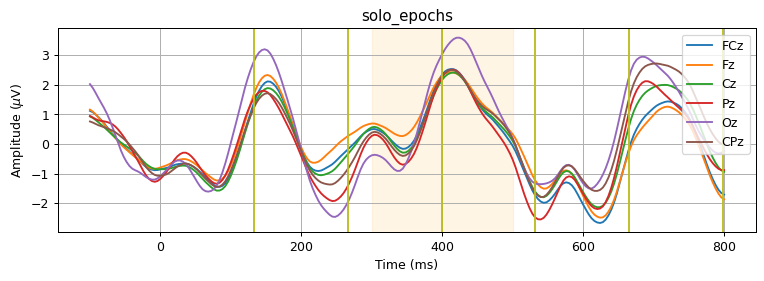

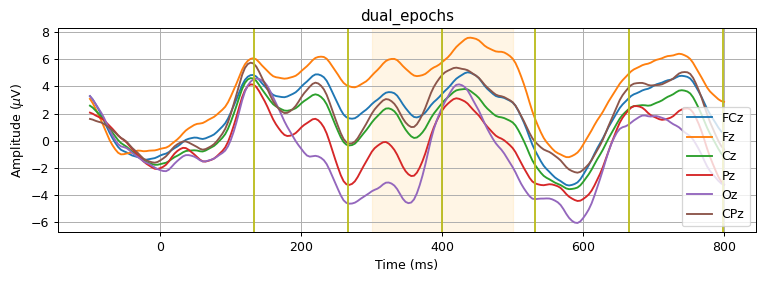

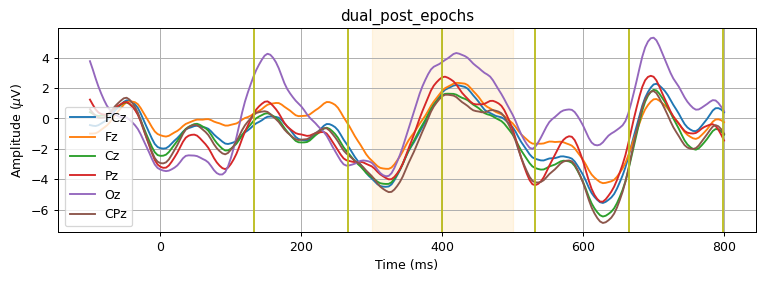

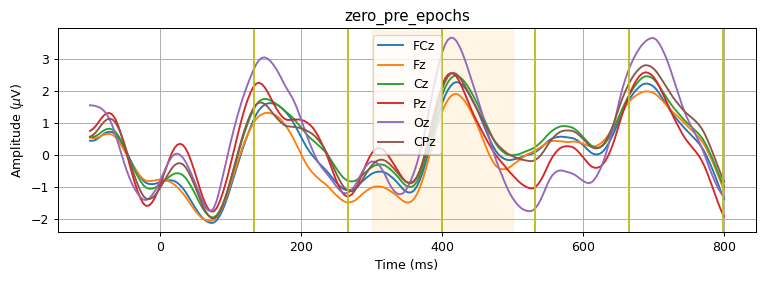

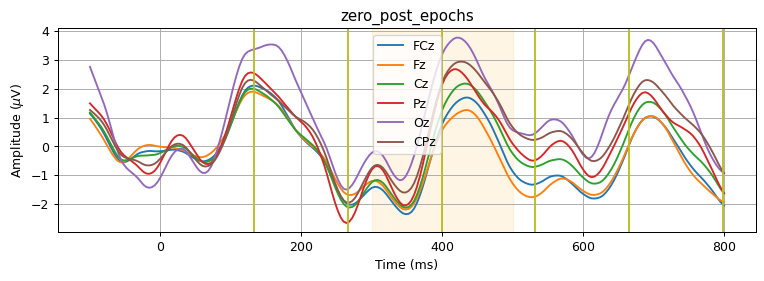

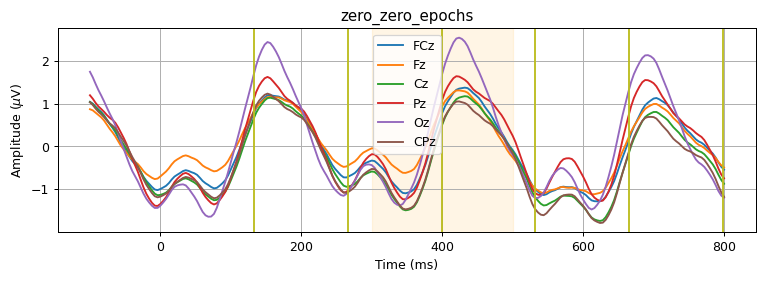

In [28]:


g_labels = [ch for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    solo_epochs_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'solo_epochs'
)
_ = ax.axvspan(300,500, color='orange', alpha=0.1)
draw_future_stim(ax)

g_labels = [ch for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    dual_epochs_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'dual_epochs'
)
_ = ax.axvspan(300,500, color='orange', alpha=0.1)
draw_future_stim(ax)

g_labels = [ch for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    dual_post_epochs_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'dual_post_epochs'
)
_ = ax.axvspan(300,500, color='orange', alpha=0.1)
draw_future_stim(ax)

g_labels = [ch for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    zero_pre_epochs_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'zero_pre_epochs'
)
_ = ax.axvspan(300,500, color='orange', alpha=0.1)
draw_future_stim(ax)

g_labels = [ch for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    zero_post_epochs_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'zero_post_epochs'
)
_ = ax.axvspan(300,500, color='orange', alpha=0.1)
draw_future_stim(ax)

g_labels = [ch for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    zero_zero_epochs_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'zero_zero_epochs'
)
_ = ax.axvspan(300,500, color='orange', alpha=0.1)
draw_future_stim(ax)


<ipython-input-4-2dd781a5d120>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)


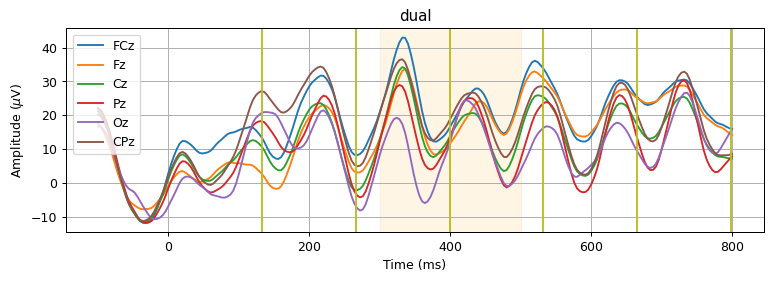

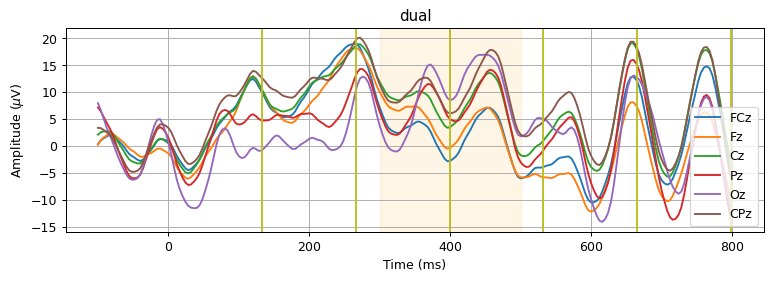

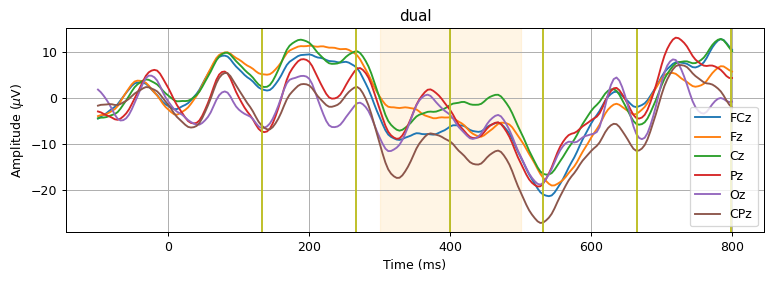

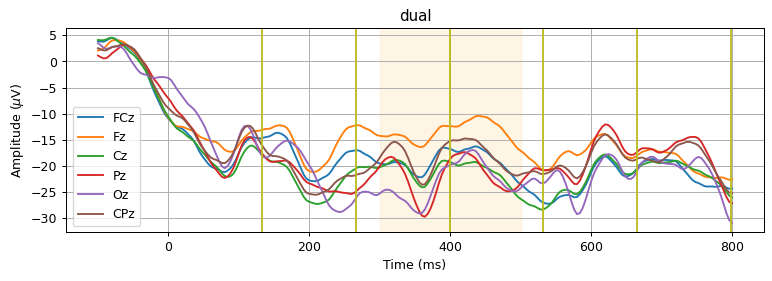

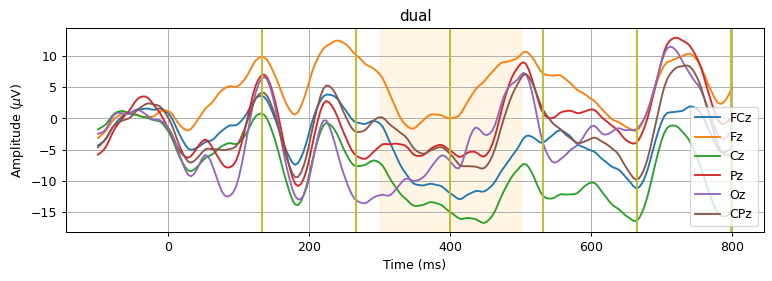

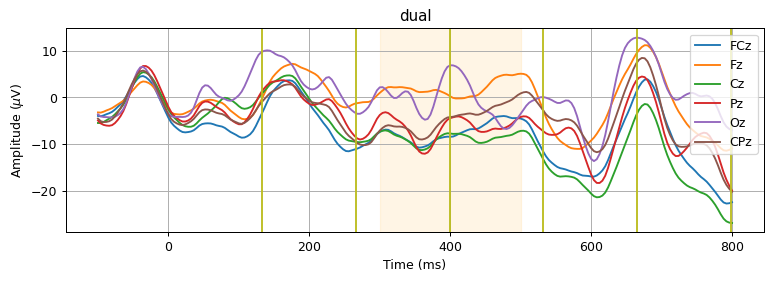

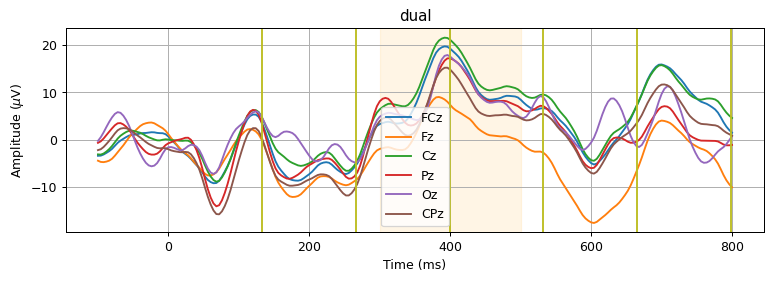

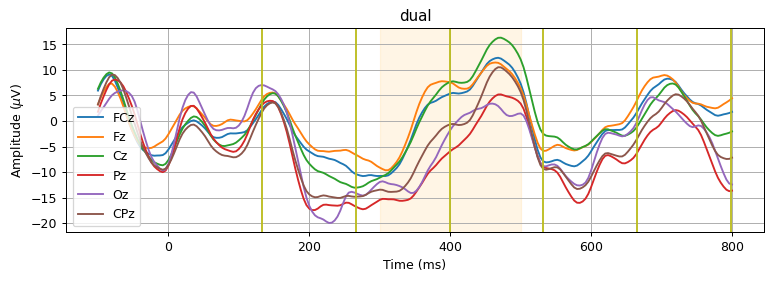

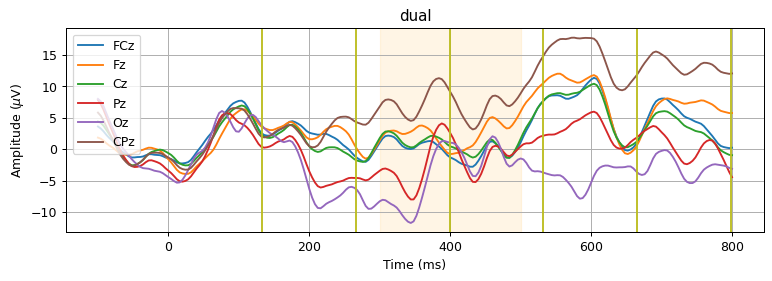

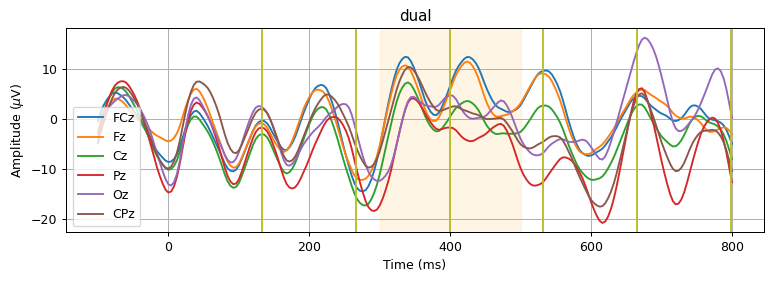

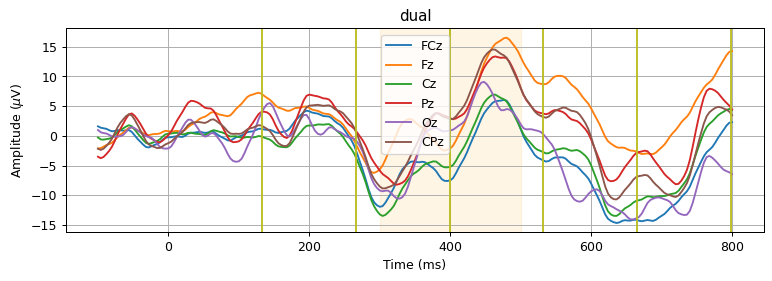

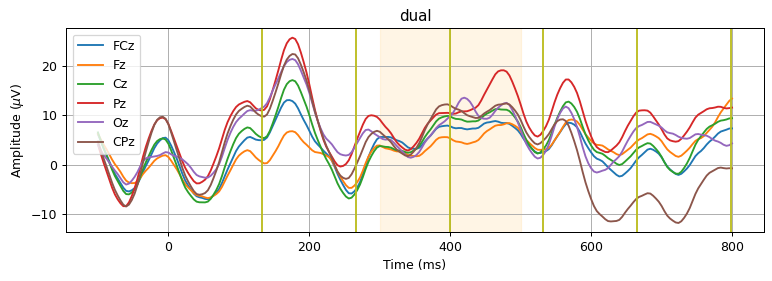

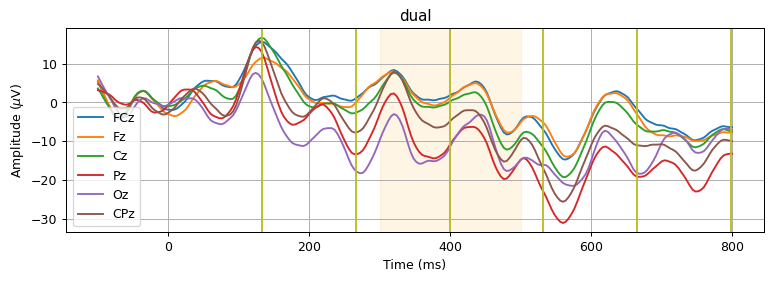

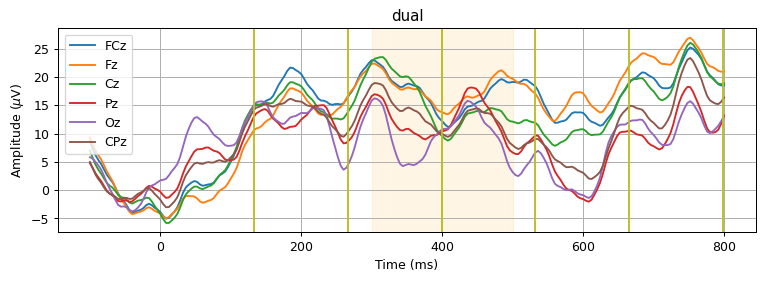

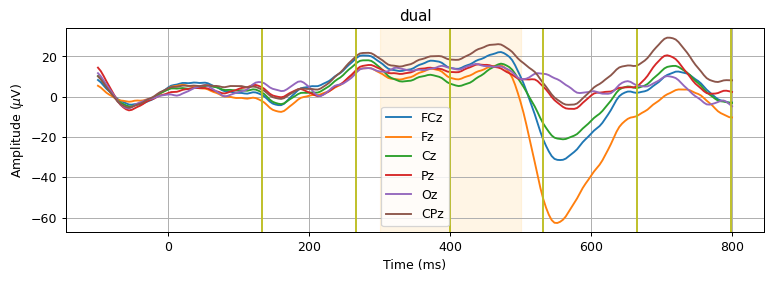

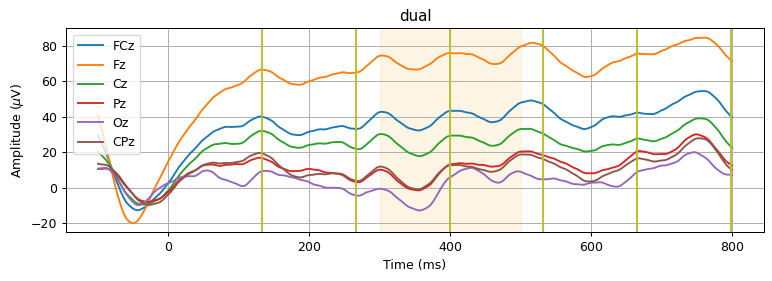

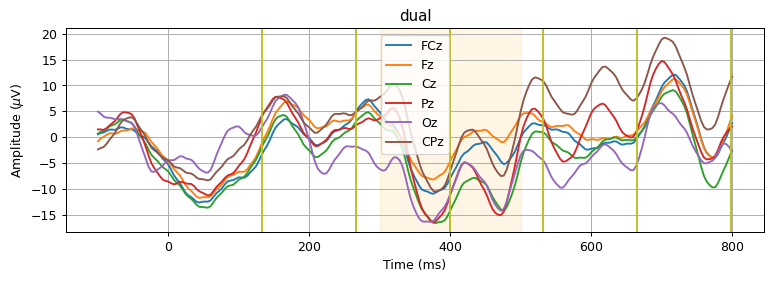

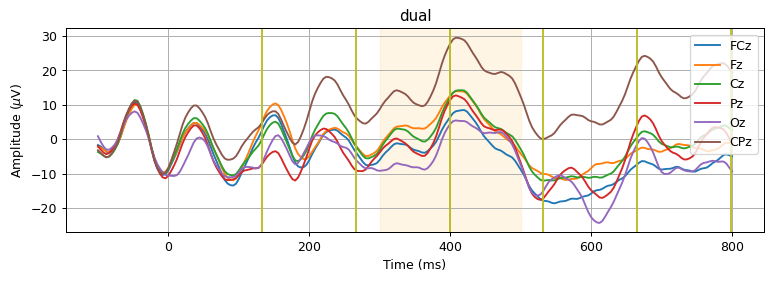

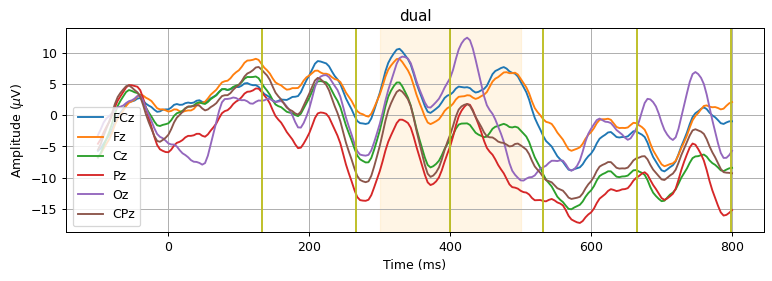

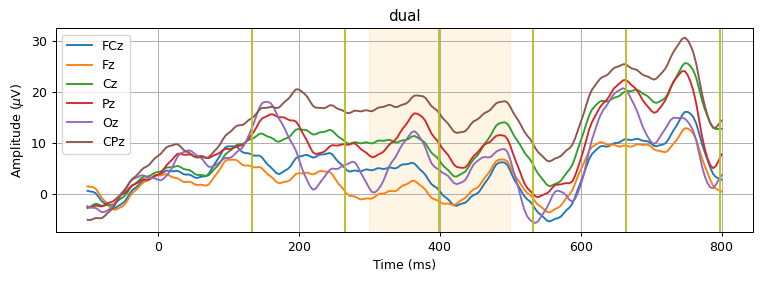

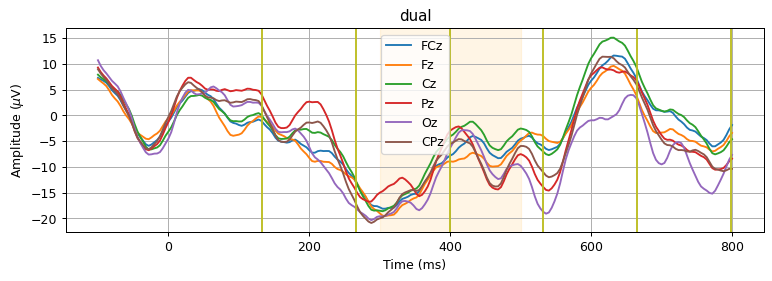

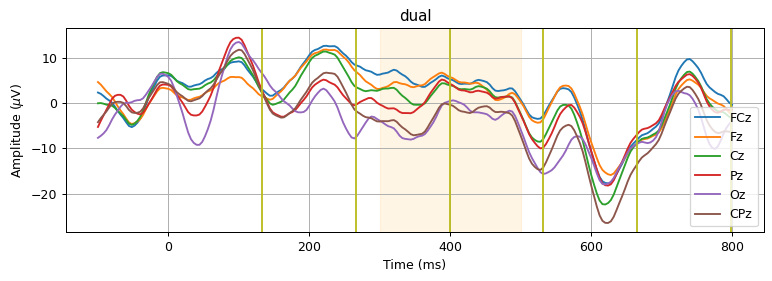

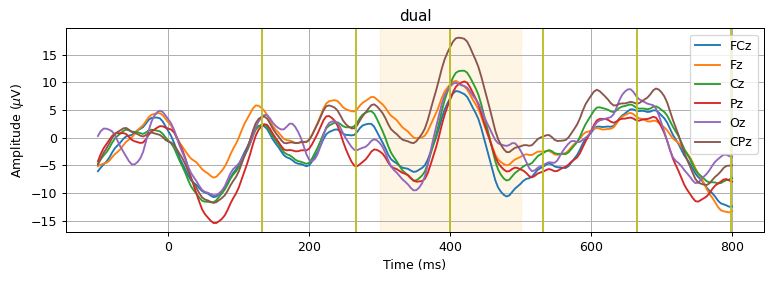

In [29]:
for epoch in dual_epochs:
    g_labels = [ch for ch in channels]
    fig, ax = plot_time_series(
        x_for_plot,
        epoch,
        labels = g_labels,
        xlabel='Time (ms)',
        ylabel=r'Amplitude ($\mu$V)',
        title=f'dual'
    )
    _ = ax.axvspan(300,500, color='orange', alpha=0.1)
    draw_future_stim(ax)

<ipython-input-4-2dd781a5d120>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)


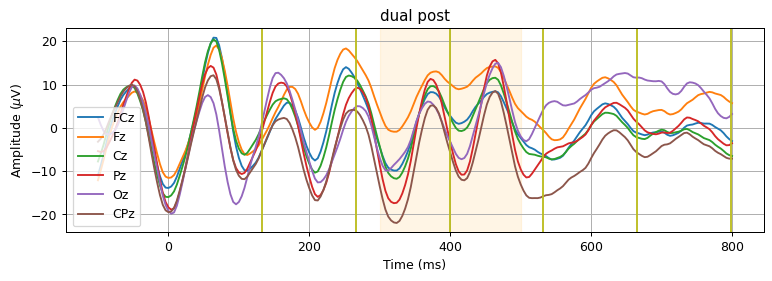

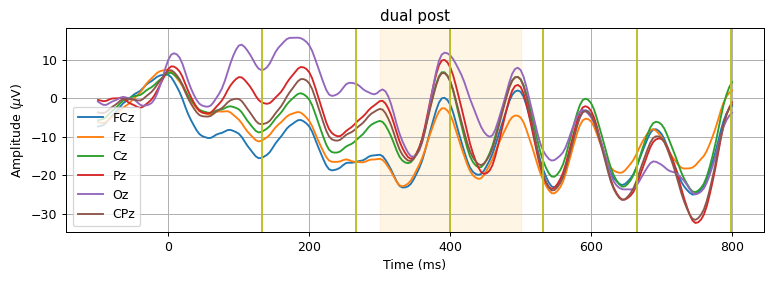

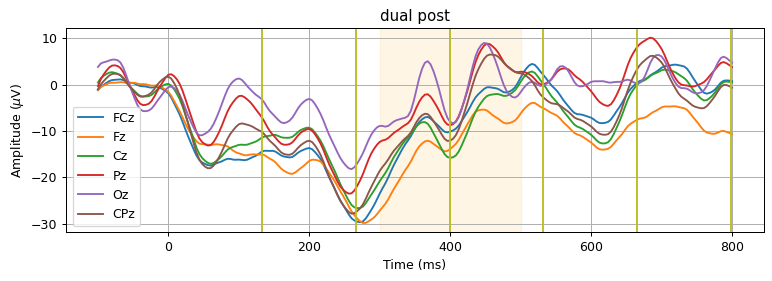

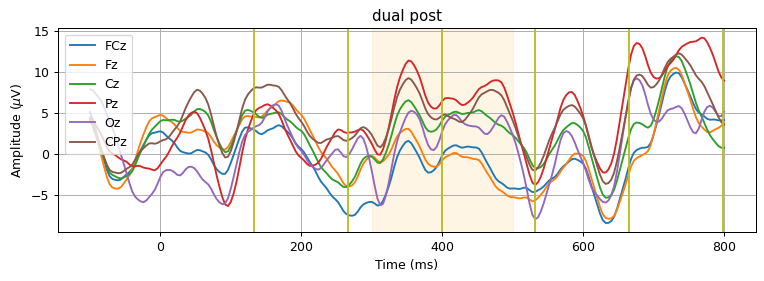

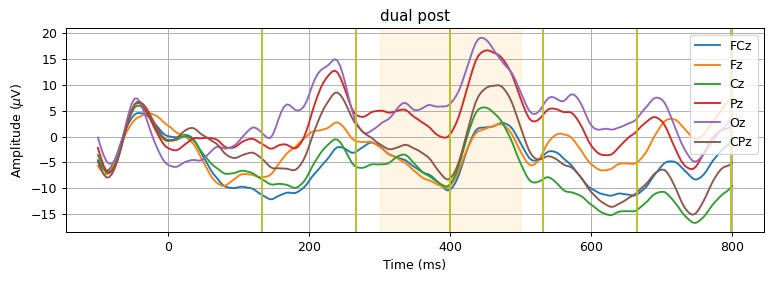

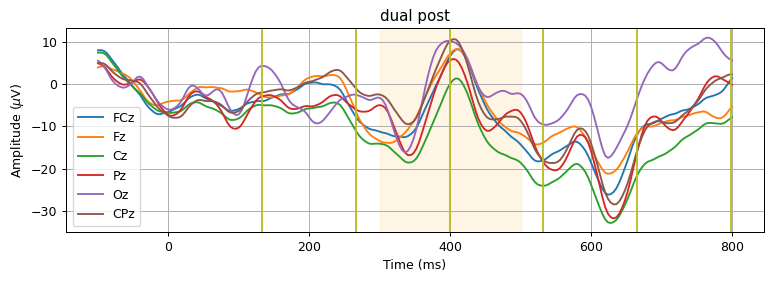

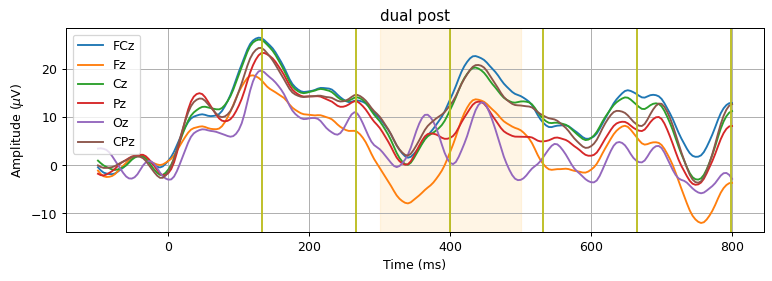

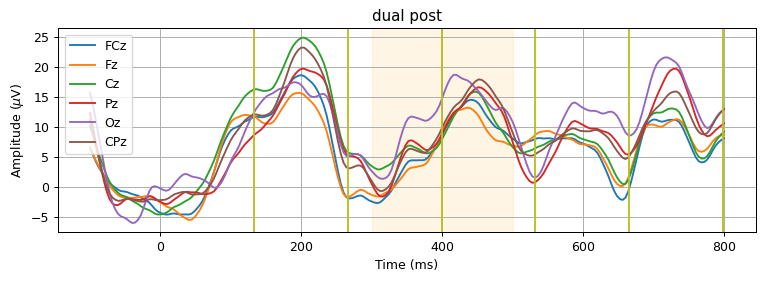

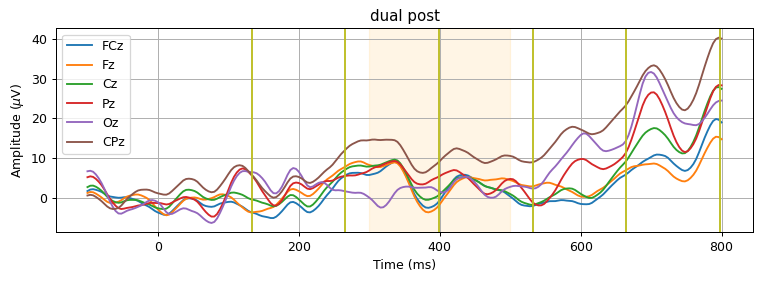

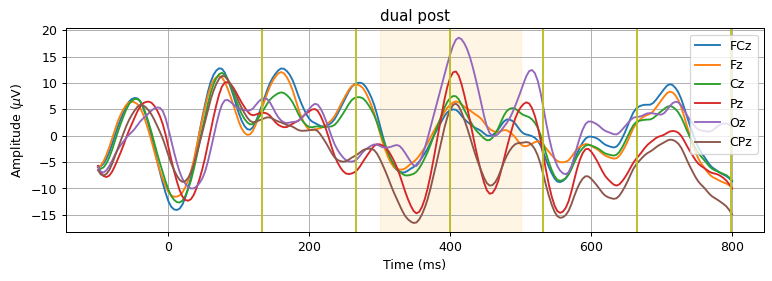

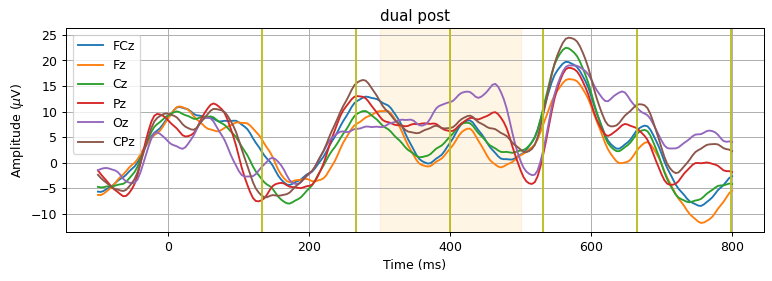

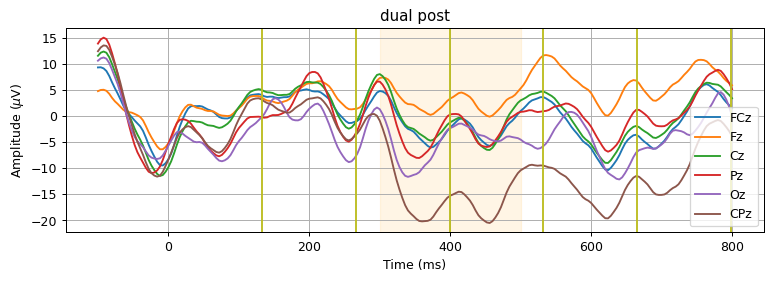

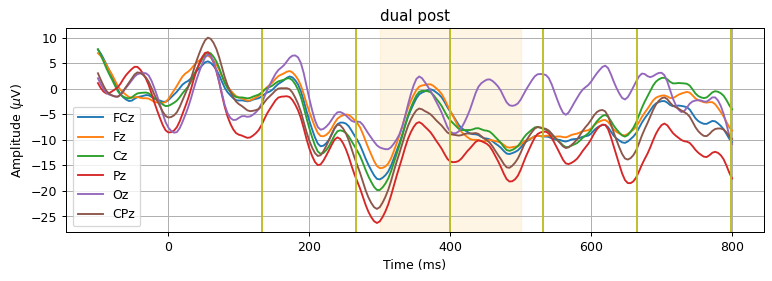

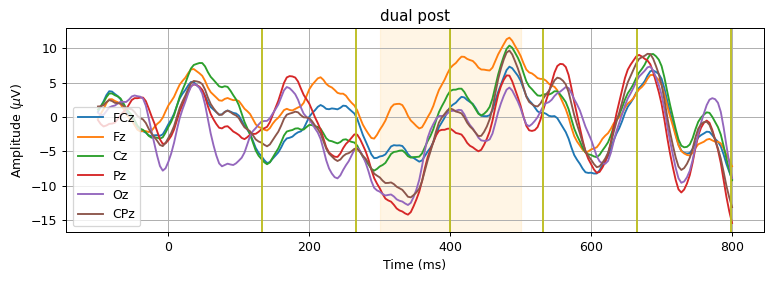

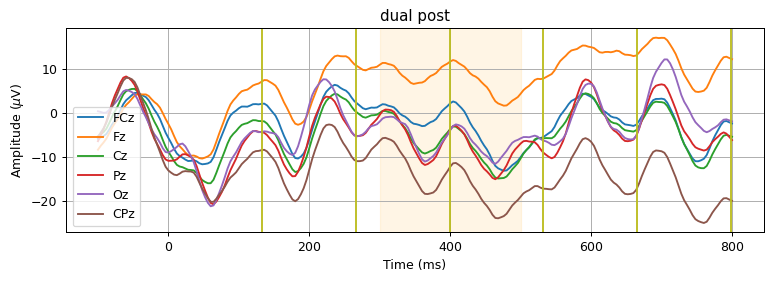

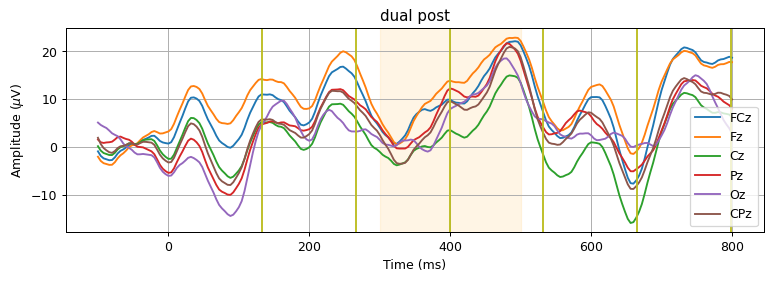

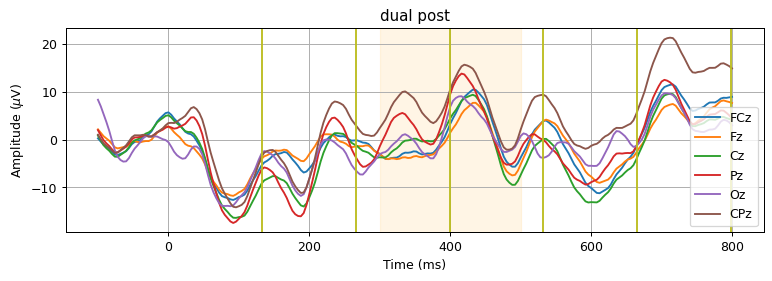

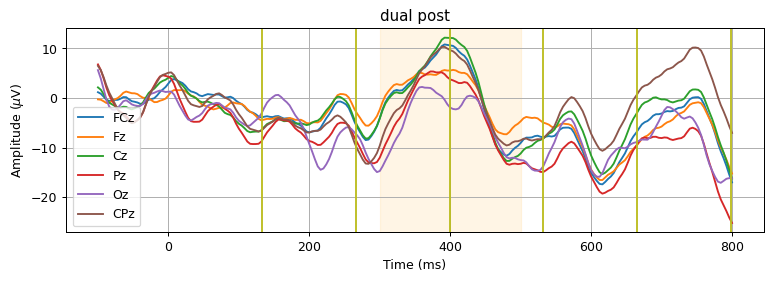

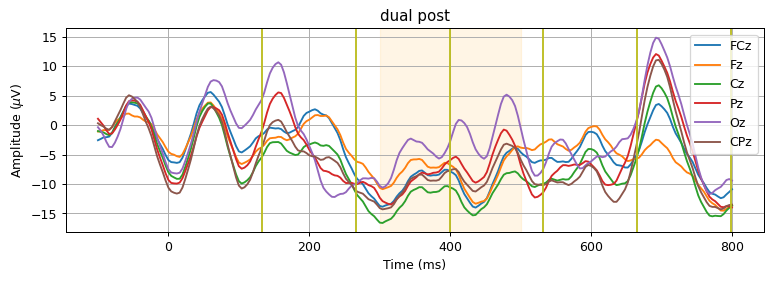

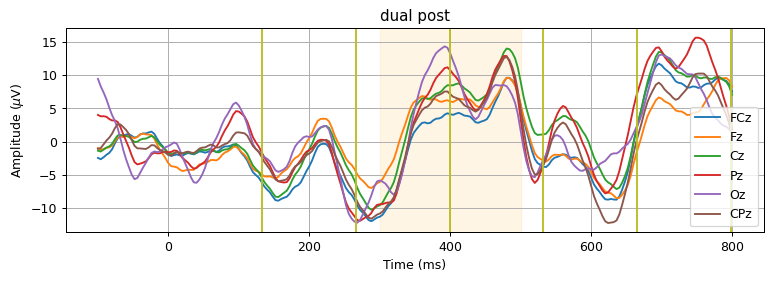

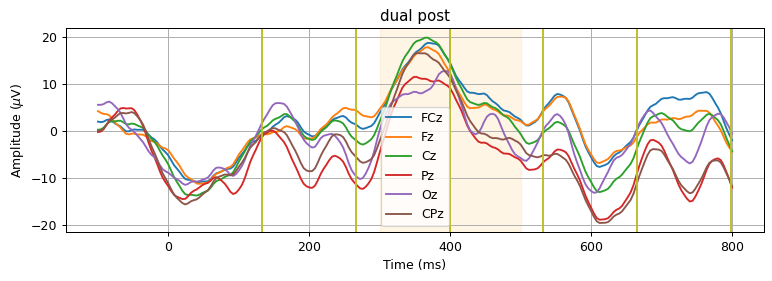

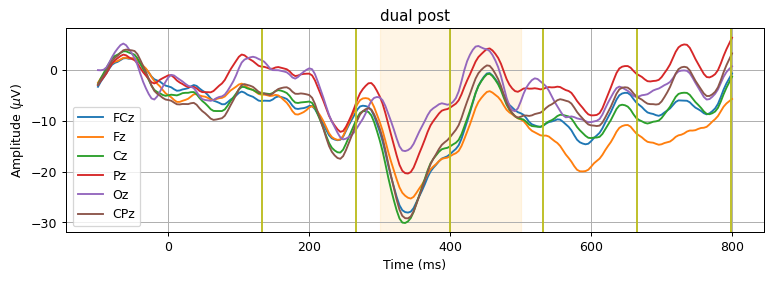

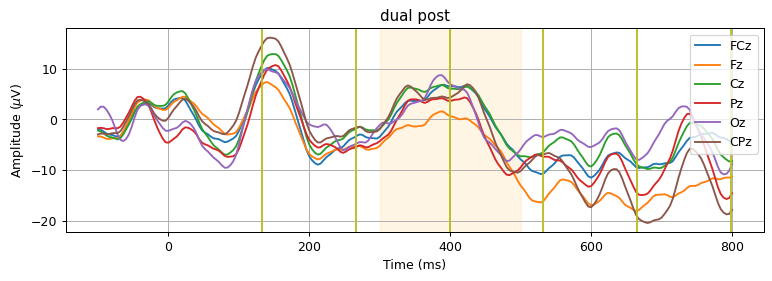

In [30]:
for epoch in dual_post_epochs:
    g_labels = [ch for ch in channels]
    fig, ax = plot_time_series(
        x_for_plot,
        epoch,
        labels = g_labels,
        xlabel='Time (ms)',
        ylabel=r'Amplitude ($\mu$V)',
        title=f'dual post'
    )
    _ = ax.axvspan(300,500, color='orange', alpha=0.1)
    draw_future_stim(ax)

In [31]:
# !pip install mne
from mne import (io, compute_raw_covariance, read_events, pick_types, Epochs, EpochsArray, create_info)
from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.viz import plot_epochs_image

In [32]:
m_epochs = np.swapaxes(all_epochs, 1, 2)
info = create_info(channels, 250, ch_types='eeg')
y_events = np.array([[i*1050, 0,ev]for i, ev in enumerate(yy)])

mne_epochs = EpochsArray(m_epochs, info, events=y_events, event_id={'non-target':0,'target':1})

Not setting metadata
Not setting metadata
1200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "gfp"


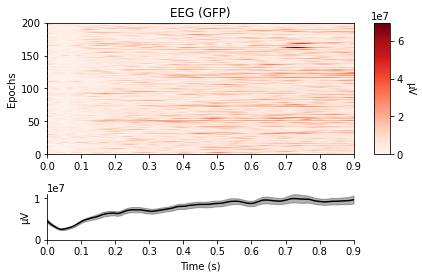

[<Figure size 432x288 with 3 Axes>]

In [33]:
plot_epochs_image(mne_epochs['target'], picks=['eeg'])

In [34]:
all_raw = np.concatenate((r1_eeg, r2_eeg))
all_raw = np.swapaxes(all_raw, 0, 1)
mne_raw = io.RawArray(all_raw, info)

Creating RawArray with float64 data, n_channels=6, n_times=125034
    Range : 0 ... 125033 =      0.000 ...   500.132 secs
Ready.


In [35]:
# Estimates signal covariance
signal_cov = compute_raw_covariance(mne_raw)

# Xdawn instance
xd = Xdawn(n_components=2, signal_cov=signal_cov)

# Fit xdawn
xd.fit(mne_epochs)

Using up to 2500 segments
Number of samples used : 125000
[done]
Computing rank from data with rank='full'
    EEG: rank 6 from info
Reducing data rank from 6 -> 6
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank='full'
    EEG: rank 6 from info
Reducing data rank from 6 -> 6
Estimating covariance using EMPIRICAL
Done.


Xdawn(correct_overlap='auto', n_components=2, reg=None,
   signal_cov=<Covariance | size : 6 x 6, n_samples : 124999, data : [[414.16373 437.2439  381.77797 338.92558 304.87907 349.36494]
 [437.2439  531.00955 386.71237 349.88921 312.4564  360.83131]
 [381.77797 386.71237 393.45969 333.89578 304.9211  343.31352]
 [338.92558 349.88921 333.89578 343.68018 316.80284 331.17555]
 [304.87907 312.4564  304.9211  316.80284 336.42874 307.19633]
 [349.36494 360.83131 343.31352 331.17555 307.19633 371.6057 ]]>)

In [36]:
epochs_denoised = xd.apply(mne_epochs)
# plot_epochs_image(epochs_denoised['target'], picks=['eeg'])
epochs_denoised

Transforming to Xdawn space
Zeroing out 4 Xdawn components
Inverse transforming to sensor space
Transforming to Xdawn space
Zeroing out 4 Xdawn components
Inverse transforming to sensor space


{'non-target': <EpochsArray |  1200 events (all good), 0 - 0.9 sec, baseline off, ~12.4 MB, data loaded,
  'non-target': 1000
  'target': 200>,
 'target': <EpochsArray |  1200 events (all good), 0 - 0.9 sec, baseline off, ~12.4 MB, data loaded,
  'non-target': 1000
  'target': 200>}

In [37]:
print(mne_raw)

<RawArray | 6 x 125034 (500.1 s), ~5.7 MB, data loaded>


Not setting metadata
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-38-972526e7cd5a>:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  plot_epochs_image(mne_epochs['target'], picks=['Pz'])


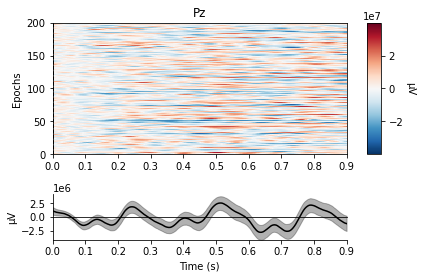

Not setting metadata
Not setting metadata
1200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-38-972526e7cd5a>:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  plot_epochs_image(epochs_denoised['target'], picks=['Pz'])


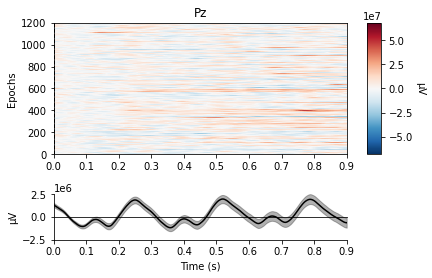

Not setting metadata
Not setting metadata
1200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


<ipython-input-38-972526e7cd5a>:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  plot_epochs_image(epochs_denoised['non-target'], picks=['Pz'])


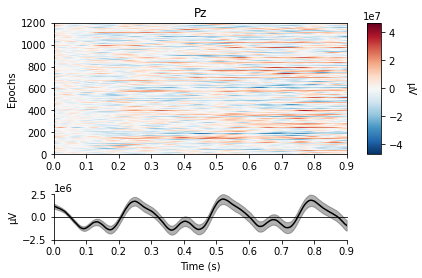

[<Figure size 432x288 with 3 Axes>]

In [38]:
plot_epochs_image(mne_epochs['target'], picks=['Pz'])
plot_epochs_image(epochs_denoised['target'], picks=['Pz'])
plot_epochs_image(epochs_denoised['non-target'], picks=['Pz'])

In [39]:
mne_epochs.info['chs']

[{'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'FCz',
  'scanno': 1,
  'logno': 1},
 {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'Fz',
  'scanno': 2,
  'logno': 2},
 {'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]),
  'unit_mul': 0 (FIFF_UNITM_NONE),
  'range': 1.0,
  'cal': 1.0,
  'kind': 2 (FIFFV_EEG_CH),
  'coil_type': 1 (FIFFV_COIL_EEG),
  'unit': 107 (FIFF_UNIT_V),
  'coord_frame': 4 (FIFFV_COORD_HEAD),
  'ch_name': 'Cz',
  'scanno': 3,
  'logno': 3},
 {'loc': array([nan, nan, nan,